In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

<hr>
<h1>1. Callibration & Undistortion</h1>

In [2]:
#Helper functions
def drawChessBoardCorners(images):
    objpoints = [] 
    imgpoints = []
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)    
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            img_chessboard = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            file_name = fname[:len(fname) - 4] + '_corners'
            mpimg.imsave(file_name + '.jpg', img_chessboard)       
    return(img, objpoints, imgpoints)

def undistortImage(image, objpoints, imgpoints, image_shape):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return(undistorted, mtx, dist)

Chessboard Images loaded
Calibrated & Undistorted


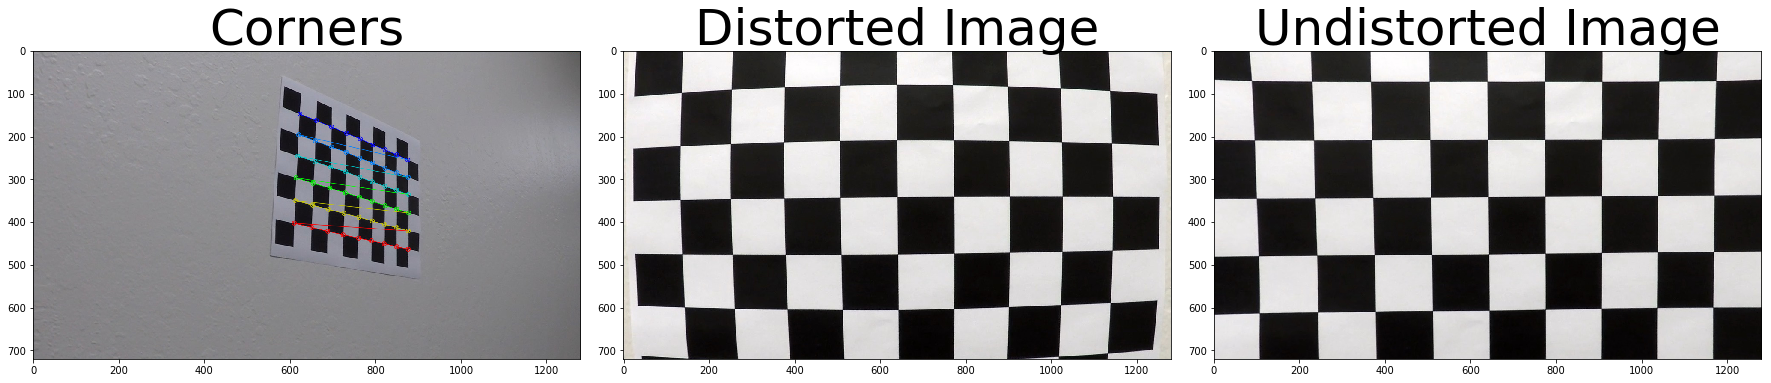

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')
print('Chessboard Images loaded')

test_image = mpimg.imread(images[0])
chessboardImage, objpoints, imgpoints = drawChessBoardCorners(images)
undistorted, mtx, dist = undistortImage(test_image, objpoints, imgpoints, test_image.shape[1::-1])

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24, 9))
f.tight_layout()
ax1.imshow(chessboardImage)
ax1.set_title('Corners', fontsize=50)
ax2.imshow(test_image)
ax2.set_title('Distorted Image', fontsize=50)
ax3.imshow(undistorted)
ax3.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Calibrated & Undistorted")

<hr>
<h2>2. Color/Gradient threshold</h2>

In [4]:
#Helper Functions
def convertRGBToHLS(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)

def convertRGBToHSV(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abssobelx = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abssobelx/np.max(abssobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbxbinary = np.zeros_like(scaled_sobel)
    sbxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbxbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobelxy = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobelxy)
    binary_output[(scaled_sobelxy >= mag_thresh[0]) & (scaled_sobelxy <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx**2)
    abs_sobely = np.sqrt(sobely**2)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctanxy = np.arctan2(abs_sobely,abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gray)
    binary_output[(arctanxy >= thresh[0]) & (arctanxy <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls_image = convertRGBToHLS(image)
    s_channel = hls_image[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv_image = convertRGBToHSV(image)
    v_channel = hsv_image[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_binary)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output

In [6]:
test_images_path = "./test_images/"
test_images = os.listdir(test_images_path)
undistorted_output = './Undistorted/'
thresholded_output = './Thresholded/'
output_path = "./output_images/"
warped_path = "./warped/"
print(test_images)

['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


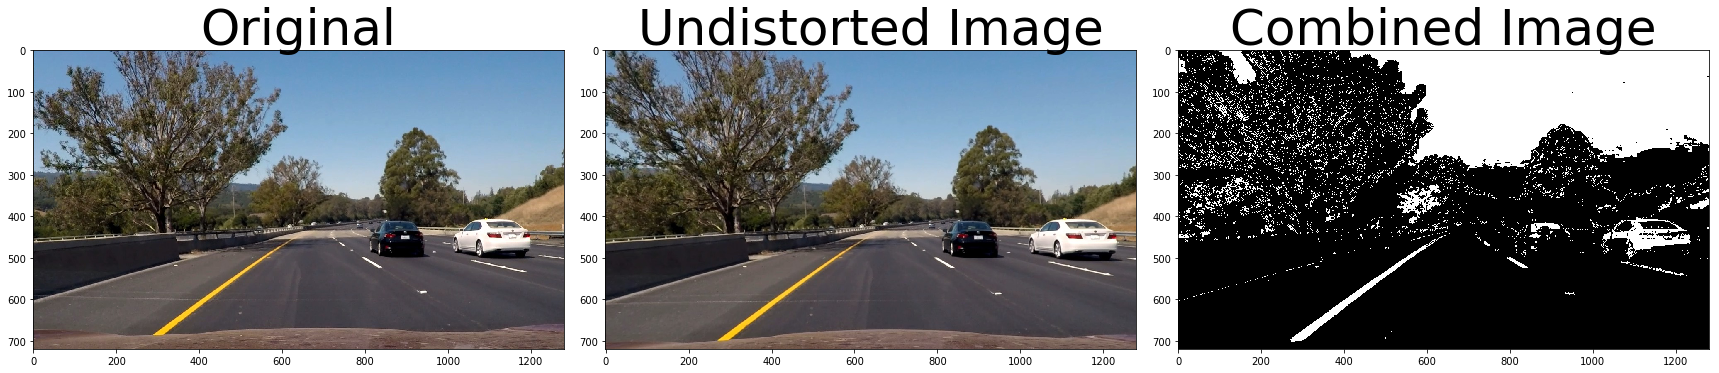

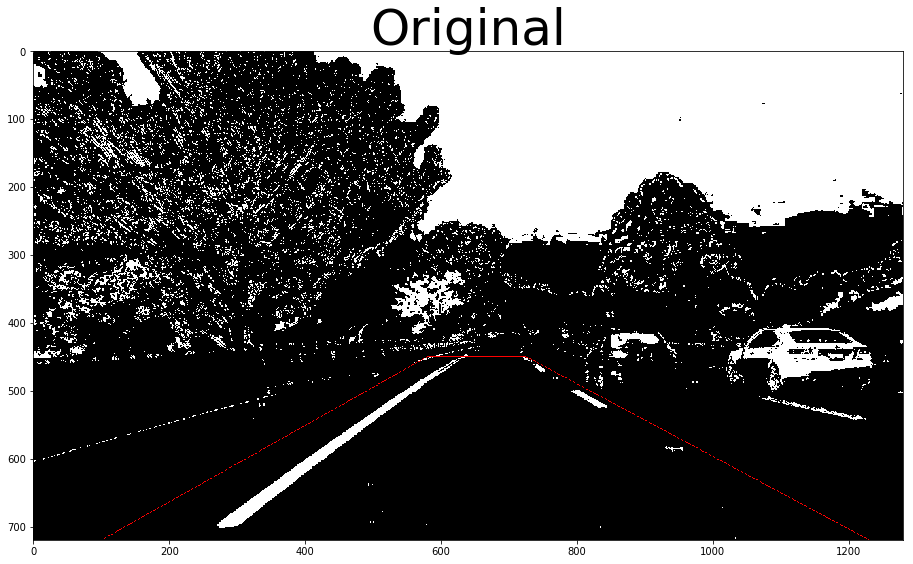

In [13]:
#| ((mag_binary == 1) & (dir_binary == 1))
for image in test_images:
  
    img = mpimg.imread(test_images_path + image)
    undistorted, mtx, dist = undistortImage(img, objpoints, imgpoints, img.shape[1::-1])   
    mpimg.imsave(undistorted_output + image, undistorted)       
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(30, 255))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(25, 255))
    mag_binary = mag_thresh(undistorted, sobel_kernel=5, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undistorted, sobel_kernel=5, thresh=(0.6, 1.2))    
    color_binary = color_threshold(undistorted, sthresh=(100,255), vthresh=(50,255))
                            
    preProcessImage = np.zeros_like(img[:,:,0])
    preProcessImage[((gradx == 1) & (grady == 1)) | (color_binary == 1) ] = 255
    temp_image = np.dstack((preProcessImage,preProcessImage,preProcessImage))
    mpimg.imsave(thresholded_output + image, temp_image)
    
    image_height = preProcessImage.shape[0]
    image_width  = preProcessImage.shape[1]
    
    source_points = np.float32([[580.,450.],[725.,450.],[1230.,image_height],[100,image_height]])
    
    destination_points = np.float32([[0,0],[image_width,0],[image_width,image_height],[0,image_height]])
    
    M = cv2.getPerspectiveTransform(source_points,destination_points)    
    warped = cv2.warpPerspective(undistorted, M, (image_width, image_height))
    #temp_warped = np.dstack((warped,warped,warped))
    mpimg.imsave(warped_path + image, warped)

    
points = np.array([[580,450],[725,450],[1230,image_height],[100,image_height]], np.int32)
points = points.reshape((-1,1,2))
test_polygon = np.copy(temp_image)
cv2.polylines(test_polygon,[points],True,(255,0,0))
    
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(preProcessImage, cmap="gray")
ax3.set_title('Combined Image', fontsize=50)

f, (ax4) = plt.subplots(1,1,figsize=(24, 9))
ax4.imshow(test_polygon)
ax4.set_title('Original', fontsize=50)